In [1]:
import os, sys

import sgpp, sgml, dproc, sgutil
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(sys.version)

from sklearn.pipeline import make_pipeline

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]


- 다른 Kaggle 노트에서 했듯이 Episode_Length_minutes의 결측 여부로 구분하지 않고 Target Encoding을 합니다.

In [2]:
sc = sgutil.SGCache('img', 'result', 'model')
p = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.ExprProcessor({
        'ELm_num': (pl.col('Episode_Length_minutes').clip(5, 120) - 5) / 115,
        'GP': (pl.col('Guest_Popularity_percentage').fill_null(pl.col('Guest_Popularity_percentage').clip(0,100).mean()).clip(0, 100) / 100),
        'HP': pl.col('Host_Popularity_percentage').clip(0, 100) / 100,
        'NAd': (pl.when(pl.col('Number_of_Ads') > 4).then(0).otherwise(pl.col('Number_of_Ads'))).fill_null(0.0) /3 ,
        'Number_of_Ads': (pl.when(pl.col('Number_of_Ads') > 4).then(0).otherwise(pl.col('Number_of_Ads'))).fill_null(0).cast(pl.Int8),
        'ELm_na': pl.col('Episode_Length_minutes').is_null(),
        'GPp_na': pl.col('Guest_Popularity_percentage').is_null(),
        'ELm_sqrt': ((pl.col('Episode_Length_minutes').clip(5, 120) - 5) / 115)  ** 0.5
    }),
    sgpp.PandasConverter(index_col = 'id')
)
p.fit(['data/train.csv'])
df_train = p.transform(['data/train.csv'])
df_test = p.transform(['data/test.csv'])
target = 'Listening_Time_minutes'
X_all = [i for i in df_train.columns if i != target]

In [3]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, cross_validate, cross_val_score, ShuffleSplit, train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
kf = KFold(5, shuffle = True, random_state = 123)
ss = ShuffleSplit(1, train_size = 0.8, random_state = 123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': lambda df, prds: root_mean_squared_error(df[target], prds),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target,
}

lr_adapter = sgml.SklearnAdapter(LinearRegression)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor, progress = 50)
xgb_adapter = sgml.XGBAdapter(xgb.XGBRegressor, progress = 50)

In [4]:
from itertools import combinations
from tqdm.notebook import tqdm 
from cuml.preprocessing import TargetEncoder

def get_tgt_rmse(df, X_tgt, target, smooth_space = np.linspace(1, 10, 10)):
    rmse_fold = list()
    best_prd = None
    best_rmse = np.inf
    for i in smooth_space:
        tgt = TargetEncoder(smooth = i, split_method ='continuous')
        prds = list()
        rmses = list()
        for train_idx, test_idx in kf.split(df[X_tgt], df[target]):
            df.iloc[train_idx].pipe(lambda x: tgt.fit(x[X_tgt], x[target]))
            df_valid = df.iloc[test_idx]
            prds.append(
                pd.Series(tgt.transform(df_valid[X_tgt]), index = df_valid.index)
            )
            rmses.append(
                root_mean_squared_error(df_valid[target], prds[-1])
            )
        rmse_fold.append(np.mean(rmses))
        if best_rmse > rmse_fold[-1]:
            best_rmse = rmse_fold[-1]
            best_prd = pd.concat(prds)
    return np.min(rmse_fold), smooth_space[np.argmin(rmse_fold)], best_prd

def get_tgt_rmse_list(df, X_values, target, smooth_space = [0.01, 0.1, 1, 10, 100, 1000]):
    results = list()
    best_prd_list = list()
    for i in tqdm(X_values):
        rmse, best_smooth, best_prd = get_tgt_rmse(df, i, target, smooth_space = smooth_space)
        results.append(
            pd.Series(
                [i, rmse, best_smooth], index = ['X_tgt', 'RMSE', 'smooth']
            )
        )
        best_prd_list.append(best_prd.rename('__'.join(i)))
    return pd.DataFrame(results).sort_values('RMSE'), pd.concat(best_prd_list, axis=1).sort_index()

def get_tgt_fit_transform(df_train, df_test, X_tgt, target, smooth):
    results = list()
    best_prd_list = list()
    tgt = TargetEncoder(smooth = smooth, split_method ='continuous')
    return pd.Series(
        tgt.fit(df_train[X_tgt], df_train[target]).transform(df_test[X_tgt]),
        index = df_test.index, name = '__'.join(X_tgt)
    )

In [5]:
# FROM 2. Feature Engineering.ipynb 
# Target Encoding1

X = [
    'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads',
    'Episode_Sentiment', 'Episode_Title', 'Genre', 'Podcast_Name', 'Publication_Day', 'Publication_Time'
]

df_c_list, df_tgt_list = list(), list()
for j in range(1, 5):
    df_c, df_tgt = sc.cache_result(
        'tgt_enc_target_{}'.format(j), lambda : get_tgt_rmse_list(df_train, [list(i) for i in combinations(X, j)], target), rerun = 0
    )
    df_c_list.append(df_c)
    df_tgt_list.append(df_tgt)

df_c1 = pd.concat(df_c_list, axis = 0)
df_tgt1 = pd.concat(df_tgt_list, axis = 1).rename(columns = lambda x: x + '_t')
X_tgt1s = {'tgt1_{}'.format(j): ['__'.join(i) + '_t' for i in combinations(X, j)] for j in range(1, 5)}
del df_c_list, df_tgt_list

df_test_tgt1 = sc.cache_result(
    'tgt_enc_target_test',
    lambda : pd.concat([
        get_tgt_fit_transform(df_train, df_test, i, target, j)
        for i, j in df_c1[['X_tgt', 'smooth']].values
    ], axis =1)
).rename(columns = lambda x: x + '_t')

df_train = dproc.join_and_assign(df_train, df_tgt1)
df_test = dproc.join_and_assign(df_test, df_test_tgt1)
del df_tgt1, df_test_tgt1

In [6]:
X = [
    'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads',
    'Episode_Sentiment', 'Episode_Title', 'Genre', 'Podcast_Name', 'Publication_Day', 'Publication_Time'
]

df_c_list, df_tgt_list = list(), list()
for j in range(1, 6):
    df_c, df_tgt = sc.cache_result(
        'tgt2_enc_target_{}'.format(j), lambda : get_tgt_rmse_list(df_train, [['Episode_Length_minutes'] + list(i) for i in combinations(X[1:], j - 1)], target), rerun = 0
    )
    df_c_list.append(df_c)
    df_tgt_list.append(df_tgt)

df_c = pd.concat(df_c_list, axis = 0)
df_tgt_2 = pd.concat(df_tgt_list, axis = 1).rename(columns = lambda x: x + '_t2')
X_tgt_2 = {'tgt_{}_2'.format(j): ['__'.join(['Episode_Length_minutes'] + list(i)) + '_t2' for i in combinations(X[1:], j - 1)] for j in range(1, 6)}
del df_c_list, df_tgt_list

In [7]:
df_test_tgt_2 = sc.cache_result(
    'tgt2_enc_target_test',
    lambda : pd.concat([
        get_tgt_fit_transform(df_train, df_test, i, target, j)
        for i, j in df_c[['X_tgt', 'smooth']].values
    ], axis =1), rerun = 0
).rename(columns = lambda x: x + '_t2')

In [8]:
df_train = dproc.join_and_assign(df_train, df_tgt_2)
df_test = dproc.join_and_assign(df_test, df_test_tgt_2)
del df_tgt_2, df_test_tgt_2

# Linear Regression 2

In [35]:
hparams = {
    'X_num': X_tgt1s['tgt1_1'] + X_tgt1s['tgt1_2'] + X_tgt1s['tgt1_3'] +  X_tgt1s['tgt1_4'] + \
            X_tgt_2['tgt_1_2'] + X_tgt_2['tgt_2_2'] + X_tgt_2['tgt_3_2'] + X_tgt_2['tgt_4_2']# + X_tgt_2['tgt_5_2']
}

result = sc.cv_result('LR_R2', df_train, kf, hparams, config, lr_adapter, result_proc = [sgml.lr_learning_result])
np.mean(result['valid_scores'])

np.float64(12.958728854787168)

In [37]:
result['valid_scores']

[np.float64(12.913741269064793),
 np.float64(12.91332471106123),
 np.float64(12.97125949462766),
 np.float64(12.980572575758234),
 np.float64(13.01474622342393)]

# XGB2 

In [16]:
hparams = {
    'X_num': X_tgt1s['tgt1_1'] + X_tgt1s['tgt1_2'] + X_tgt1s['tgt1_3'] +  X_tgt1s['tgt1_4'] + \
        X_tgt_2['tgt_1_2'], #+ X_tgt_2['tgt_2_2'] + X_tgt_2['tgt_3_2'] + X_tgt_2['tgt_4_2'] + X_tgt_2['tgt_5_2'],
    'model_params': {'max_depth': 11, 'n_estimators': 500, 'colsample_bytree': 0.7, 'learning_rate': 0.007},
    'validation_fraction': 0.1
}

result = sgml.cv(df_train, kf, hparams, config, xgb_adapter, use_gpu = True, rerun = 1)
np.mean(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/500 [00:00<?, ?it/s]

np.float32(15.240668)

In [ ]:
hparams = {
    'X_num': X_tgt1s['tgt1_1'] + X_tgt1s['tgt1_2'] + X_tgt1s['tgt1_3'] +  X_tgt1s['tgt1_4'] + \
        X_tgt_2['tgt_1_2'] + X_tgt_2['tgt_2_2'] + X_tgt_2['tgt_3_2'] + X_tgt_2['tgt_4_2'] + X_tgt_2['tgt_5_2'],
    'model_params': {'max_depth': 11, 'n_estimators': 1500, 'colsample_bytree': 0.7, 'learning_rate': 0.007},
}

result = sc.cv_result('XGB_2', df_train, kf, hparams, config, xgb_adapter, use_gpu = True, rerun = 1)
np.mean(result['valid_scores'])

In [15]:
sc.read_prd('XGB_2')

array([48.389637, 67.25354 , 46.280693, ..., 16.778877, 81.66974 ,
       11.199295], shape=(750000,), dtype=float32)

In [16]:
prd_off = pd.Series(
    sc.read_prd('XGB_2'), index = df_train.index
)

In [18]:
(df_train[target] - prd_off).sort_values()

id
551931    -73.819794
354394    -71.448586
138604    -69.686058
50704     -69.058617
206754    -66.664749
             ...    
391491     96.640778
483905     98.030952
583239    101.363632
3859      102.183578
63965     106.190018
Length: 750000, dtype: float32

In [12]:
X_all

['Podcast_Name',
 'Episode_Title',
 'Episode_Length_minutes',
 'Genre',
 'Host_Popularity_percentage',
 'Publication_Day',
 'Publication_Time',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Sentiment',
 'ELm_num',
 'GP',
 'HP',
 'NAd',
 'ELm_na',
 'GPp_na',
 'ELm_sqrt']

In [13]:
a, b = None, None
for i, (train_idx, valid_idx) in enumerate(kf.split(df_train, df_train[target])):
    if i == 0:
        a = df_train.iloc[valid_idx]
    elif i == 1:
        b = df_train.iloc[valid_idx]

In [14]:
from scipy.stats import chi2_contingency
for i in X_all:
    print(
        i, chi2_contingency(
            pd.concat([
                a[i].value_counts().rename('a'),
                b[i].value_counts().rename('b'),
            ], axis=1)
        )[1]
    )

Podcast_Name 0.3144325570282423
Episode_Title 0.577316907832015
Episode_Length_minutes nan
Genre 0.2886007684207449
Host_Popularity_percentage nan
Publication_Day 0.327130728815115
Publication_Time 0.5372906074856663
Guest_Popularity_percentage nan
Number_of_Ads 0.2668851442384523
Episode_Sentiment 0.2068476190140054
ELm_num nan
GP nan
HP nan
NAd 0.2668851442384523
ELm_na 0.7577088730708249
GPp_na 0.09860643024865465
ELm_sqrt nan


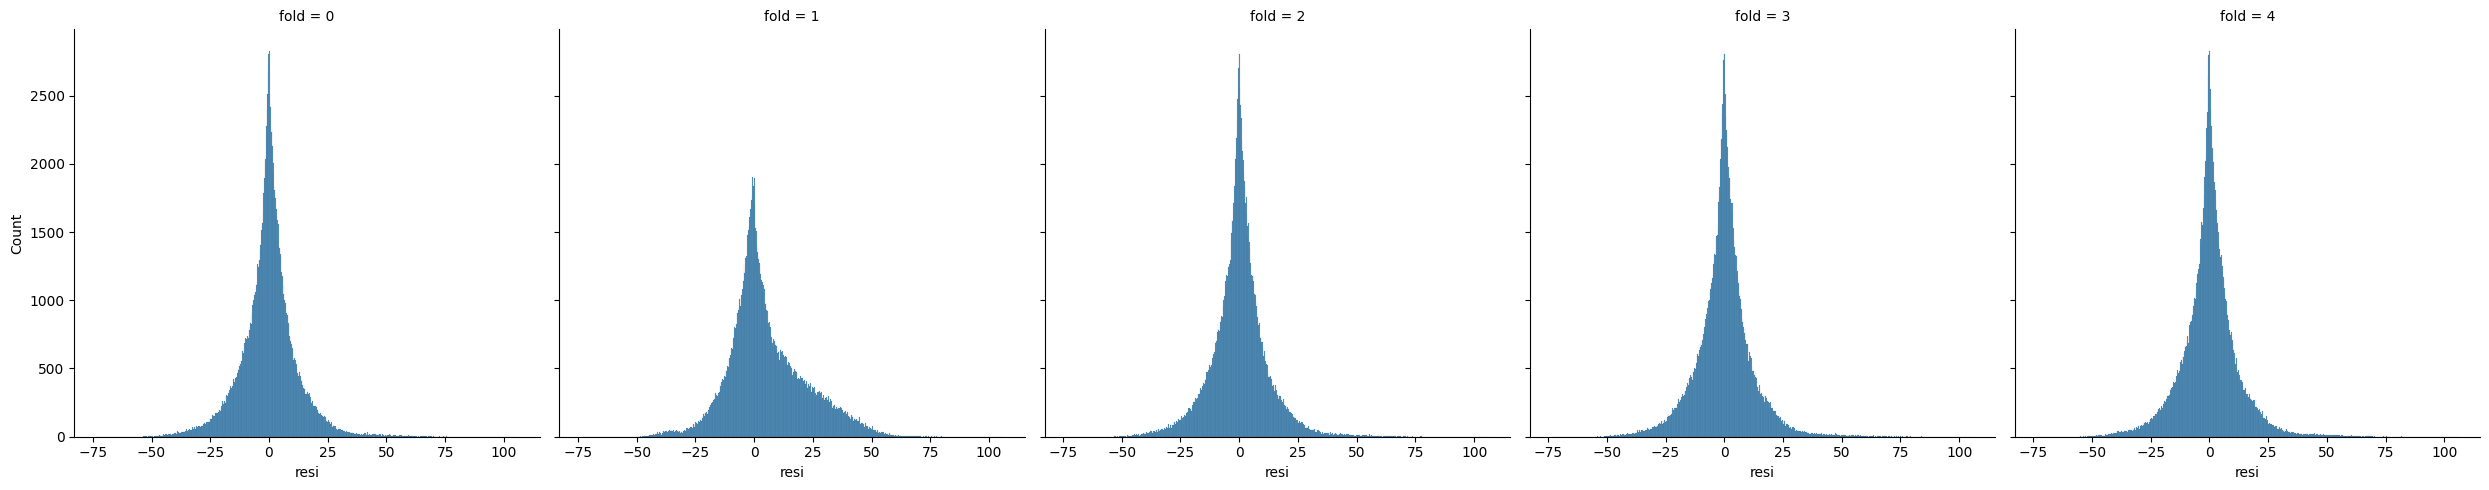

In [27]:
sns.displot(
    pd.concat(err_list),  x = 'resi', col = 'fold'
)

- Target Encoding을 Cross Validation으로 Cross Fitting해놓고 입력 변수로 사용할 경우 Data leakage를 발생시킬 수 있습니다.

- 위 문제에서 Fold = 1의 테스트 성능이 떨어진 것은 Data Leakage에 의한 것입니다.

- 따라 Target Encoding은 Train셋으로 매번 Fit을 시키던지 아니면, Train에서 Target Enocoder를 fit_transform(기본적으로 전달된 데이터셋으로 cross fit 시킨 결과를 반환)